In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
uploaded = files.upload()

Saving combined_all.csv to combined_all.csv


/tmp/ipython-input-1097733413.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_clean["alpha_smooth"] = savgol_filter(avg_clean["alpha_raw"], window_length=11, polyorder=2)


✅ Saved cleaned results as thermal_expansion_final.csv

Average α = 2.220e-06 1/K
Std deviation = 9.749e-05 1/K
Data points used: 126 / 3000


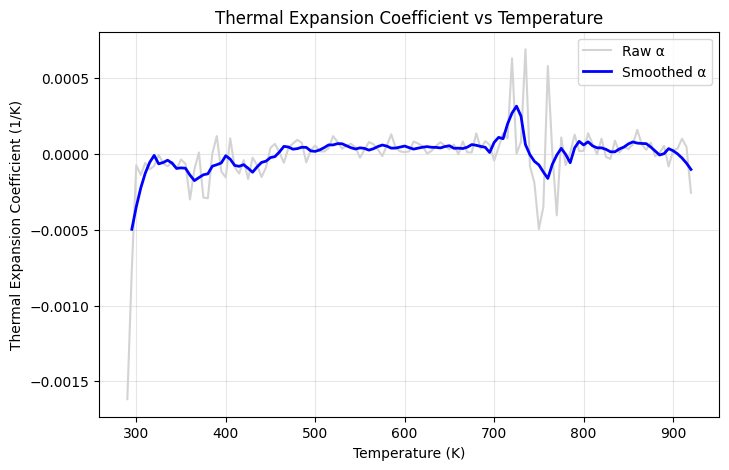

In [ ]:
# --- Step 1: Import libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# --- Step 2: Load your raw MD data ---
df = pd.read_csv("combined_all.csv")

# --- Step 3: Basic cleaning ---
df = df.dropna(subset=["Temp", "Vol"])
df = df.sort_values("Temp").reset_index(drop=True)

# --- Step 4: Average data over temperature bins (5 K intervals) ---
df["Temp_bin"] = (df["Temp"] // 5) * 5
avg = df.groupby("Temp_bin")[["Vol", "Etot"]].mean().reset_index()
avg = avg.rename(columns={"Temp_bin": "Temp"})

# --- Step 5: Compute derivative and α ---
avg["dV/dT"] = np.gradient(avg["Vol"], avg["Temp"])
avg["alpha_raw"] = avg["dV/dT"] / avg["Vol"]

# --- Step 6: Remove unrealistic outliers ---
alpha_mean = avg["alpha_raw"].mean()
alpha_std = avg["alpha_raw"].std()
mask = (avg["alpha_raw"] > alpha_mean - 5 * alpha_std) & (avg["alpha_raw"] < alpha_mean + 5 * alpha_std)
avg_clean = avg[mask]

# --- Step 7: Smooth α curve ---
if len(avg_clean) >= 11:
    avg_clean["alpha_smooth"] = savgol_filter(avg_clean["alpha_raw"], window_length=11, polyorder=2)
else:
    avg_clean["alpha_smooth"] = avg_clean["alpha_raw"]

# --- Step 8: Save final output ---
avg_clean.to_csv("thermal_expansion_final.csv", index=False)
print("✅ Saved cleaned results as thermal_expansion_final.csv")

# --- Step 9: Summary stats ---
print(f"\nAverage α = {avg_clean['alpha_smooth'].mean():.3e} 1/K")
print(f"Std deviation = {avg_clean['alpha_smooth'].std():.3e} 1/K")
print(f"Data points used: {len(avg_clean)} / {len(df)}")

# --- Step 10: Plot results ---
plt.figure(figsize=(8,5))
plt.plot(avg["Temp"], avg["alpha_raw"], color='lightgray', label="Raw α")
plt.plot(avg_clean["Temp"], avg_clean["alpha_smooth"], color='blue', linewidth=2, label="Smoothed α")
plt.xlabel("Temperature (K)")
plt.ylabel("Thermal Expansion Coefficient (1/K)")
plt.title("Thermal Expansion Coefficient vs Temperature")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
from google.colab import files
files.download("thermal_expansion_final.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

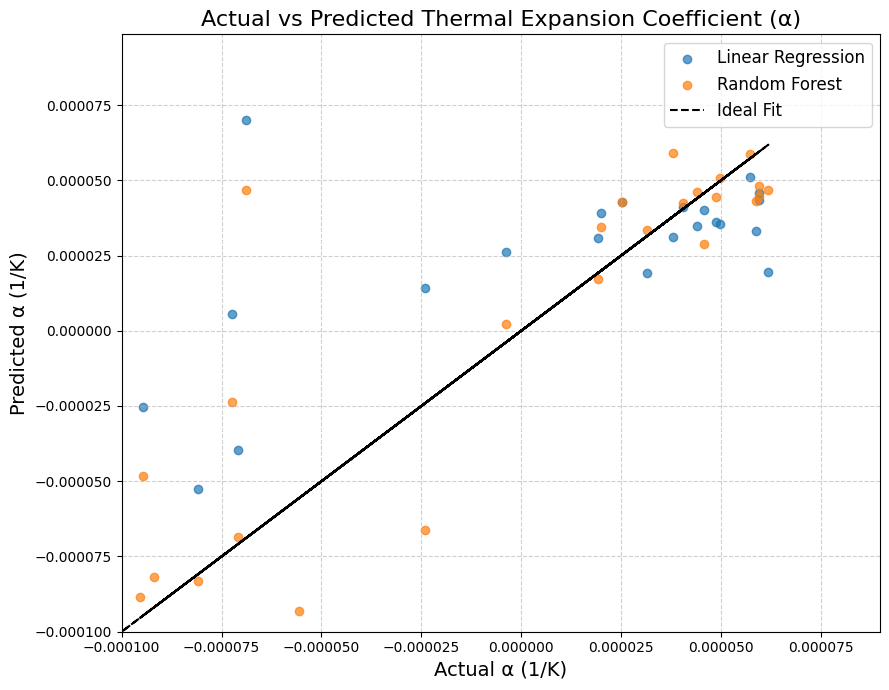

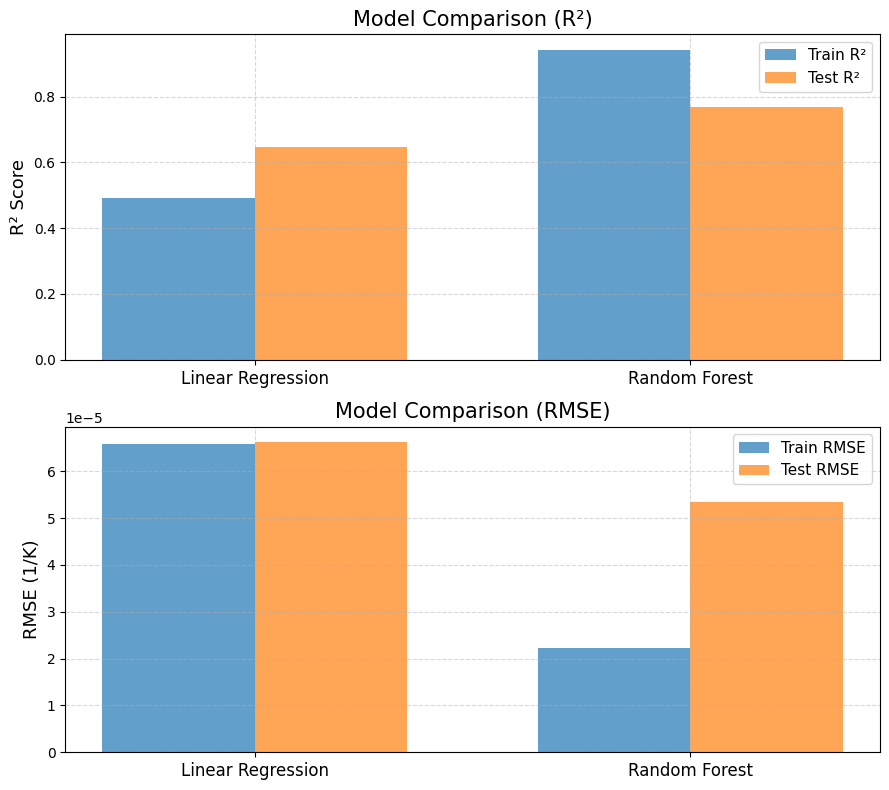

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


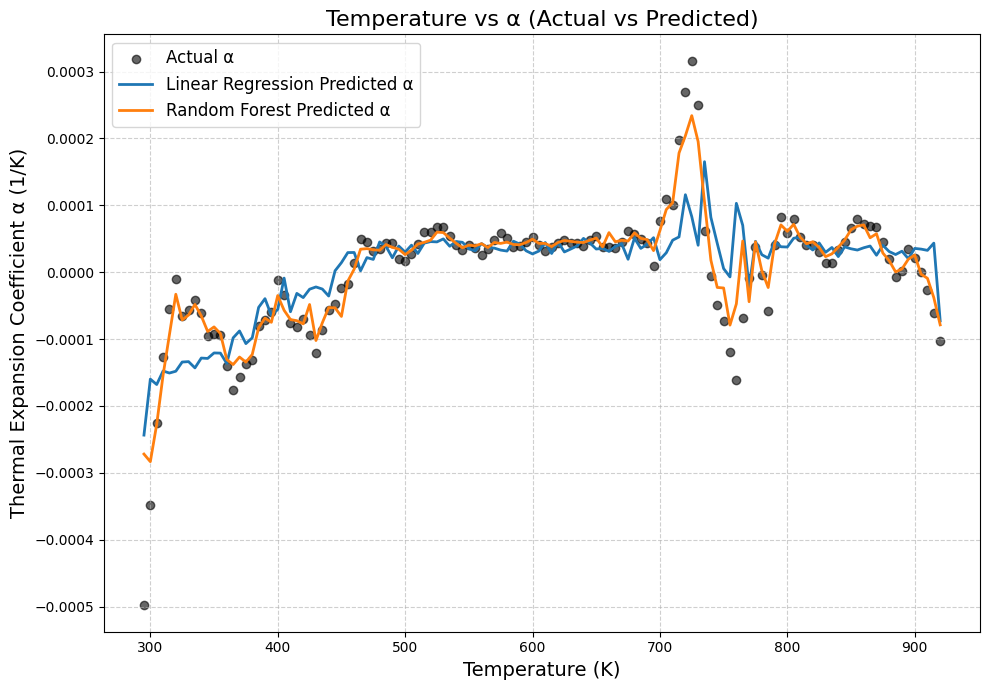


🏆 Best Model: Random Forest
   R² (Test): 0.7695
   RMSE (Test): 5.3362e-05

--- Model Performance Summary ---

Linear Regression:
  Train R²   = 0.4913
  Test  R²   = 0.6452
  Train RMSE = 0.000066
  Test  RMSE = 0.000066

Random Forest:
  Train R²   = 0.9418
  Test  R²   = 0.7695
  Train RMSE = 0.000022
  Test  RMSE = 0.000053


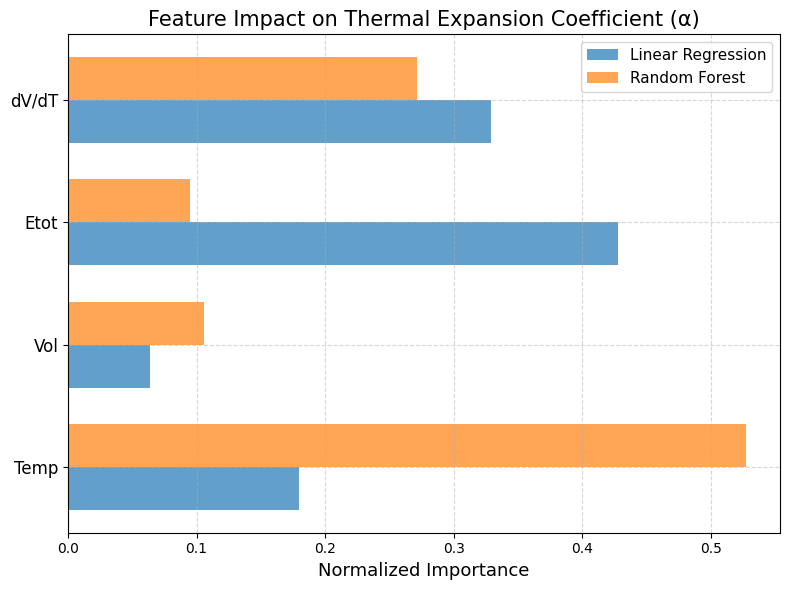


--- Feature Impact Summary ---
Feature  Linear Regression  Random Forest
   Temp             0.1797         0.5275
    Vol             0.0640         0.1060
   Etot             0.4275         0.0952
  dV/dT             0.3288         0.2713


In [ ]:
# --- Thermal Expansion Alpha Prediction and Model Comparison ---
# Author: ChatGPT
# Purpose: Predict α using Linear Regression and Random Forest, visualize and compare models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# --- Step 1: Load Data ---
df = pd.read_csv("thermal_expansion_final.csv")

# --- Step 2: Select Features and Target ---
features = ['Temp', 'Vol', 'Etot', 'dV/dT']
target = 'alpha_smooth'

# Drop NaNs
df = df.dropna(subset=features + [target])

X = df[features].values
y = df[target].values

# --- Step 3: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 4: Define Models ---
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=150, random_state=42)
}

results = {}

# --- Step 5: Train & Evaluate Models ---
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    results[name] = {
        'model': model,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'y_pred_test': y_pred_test
    }
# --- Step 6: Actual vs Predicted α ---
plt.figure(figsize=(9,7))
for name, res in results.items():
    plt.scatter(y_test, res['y_pred_test'], label=name, alpha=0.7)

plt.plot(y_test, y_test, 'k--', label='Ideal Fit')
plt.xlabel('Actual α (1/K)', fontsize=14)
plt.ylabel('Predicted α (1/K)', fontsize=14)
plt.title('Actual vs Predicted Thermal Expansion Coefficient (α)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Force both axes to start from -0.0001
plt.xlim(-0.0001, None)
plt.ylim(-0.0001, None)

plt.tight_layout()
plt.show()




# --- Step 7: Bar Graph Comparison (R² and RMSE) ---
labels = list(models.keys())
r2_train_vals = [results[m]['r2_train'] for m in labels]
r2_test_vals = [results[m]['r2_test'] for m in labels]
rmse_train_vals = [results[m]['rmse_train'] for m in labels]
rmse_test_vals = [results[m]['rmse_test'] for m in labels]

fig, axs = plt.subplots(2, 1, figsize=(9,8))

bar_width = 0.35
x = np.arange(len(labels))

# R²
axs[0].bar(x - bar_width/2, r2_train_vals, bar_width, label='Train R²', alpha=0.7)
axs[0].bar(x + bar_width/2, r2_test_vals, bar_width, label='Test R²', alpha=0.7)
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels, fontsize=12)
axs[0].set_ylabel('R² Score', fontsize=13)
axs[0].set_title('Model Comparison (R²)', fontsize=15)
axs[0].legend(fontsize=11)
axs[0].grid(True, linestyle='--', alpha=0.5)

# RMSE
axs[1].bar(x - bar_width/2, rmse_train_vals, bar_width, label='Train RMSE', alpha=0.7)
axs[1].bar(x + bar_width/2, rmse_test_vals, bar_width, label='Test RMSE', alpha=0.7)
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels, fontsize=12)
axs[1].set_ylabel('RMSE (1/K)', fontsize=13)
axs[1].set_title('Model Comparison (RMSE)', fontsize=15)
axs[1].legend(fontsize=11)
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# --- Step 8: Temperature vs Predicted α ---
plt.figure(figsize=(10,7))
plt.scatter(df['Temp'], df['alpha_smooth'], color='black', label='Actual α', alpha=0.6)

for name, res in results.items():
    model = res['model']
    y_pred_all = model.predict(df[features])
    plt.plot(df['Temp'], y_pred_all, label=f'{name} Predicted α', linewidth=2)

plt.xlabel('Temperature (K)', fontsize=14)
plt.ylabel('Thermal Expansion Coefficient α (1/K)', fontsize=14)
plt.title('Temperature vs α (Actual vs Predicted)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Step 9: Identify Best Model ---
best_model = min(results.items(), key=lambda x: x[1]['rmse_test'])
print(f"\n🏆 Best Model: {best_model[0]}")
print(f"   R² (Test): {best_model[1]['r2_test']:.4f}")
print(f"   RMSE (Test): {best_model[1]['rmse_test']:.4e}")
# --- Step 8.5: Print R² and RMSE for all models ---
print("\n--- Model Performance Summary ---")
for name, res in results.items():
    print(f"\n{name}:")
    print(f"  Train R²   = {res['r2_train']:.4f}")
    print(f"  Test  R²   = {res['r2_test']:.4f}")
    print(f"  Train RMSE = {res['rmse_train']:.6f}")
    print(f"  Test  RMSE = {res['rmse_test']:.6f}")
# --- Step 10: Feature Importance / Impact on α ---

# Prepare figure
plt.figure(figsize=(8,6))

# For Linear Regression: use absolute coefficients normalized
lin_importance = np.abs(results['Linear Regression']['model'].coef_)
lin_importance = lin_importance / np.sum(lin_importance)

# For Random Forest: use built-in feature importances normalized
rf_importance = results['Random Forest']['model'].feature_importances_
rf_importance = rf_importance / np.sum(rf_importance)

# Combine into a DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Linear Regression': lin_importance,
    'Random Forest': rf_importance
})

# Plot horizontal bar graph
bar_width = 0.35
y_pos = np.arange(len(features))

plt.barh(y_pos - bar_width/2, importance_df['Linear Regression'],
         height=bar_width, label='Linear Regression', alpha=0.7)
plt.barh(y_pos + bar_width/2, importance_df['Random Forest'],
         height=bar_width, label='Random Forest', alpha=0.7)

plt.yticks(y_pos, features, fontsize=12)
plt.xlabel('Normalized Importance', fontsize=13)
plt.title('Feature Impact on Thermal Expansion Coefficient (α)', fontsize=15)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Optional: Display table of importances ---
print("\n--- Feature Impact Summary ---")
print(importance_df.to_string(index=False, float_format='%.4f'))

